Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [74]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from tensorflow import keras
from six.moves import cPickle as pickle
from six.moves import range
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import os

In [4]:
pickle_file = r"D:\Github\NLP\Artificial_Intelligence_for_NLP\Week_09_0831_kmeans_NN\assignments\notMNIST.pickle"

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [6]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [12]:
batch_size = 16
patch_size = 5
# filter numbers
depth = 16
# full connection layers neuron number
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [15]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
            print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.151056
Minibatch accuracy: 18.8%
Validation accuracy: 8.7%
Test accuracy: 8.5%
Minibatch loss at step 50: 2.040035
Minibatch accuracy: 18.8%
Validation accuracy: 48.3%
Test accuracy: 53.3%
Minibatch loss at step 100: 1.271775
Minibatch accuracy: 68.8%
Validation accuracy: 70.9%
Test accuracy: 78.0%
Minibatch loss at step 150: 1.246942
Minibatch accuracy: 62.5%
Validation accuracy: 74.5%
Test accuracy: 81.8%
Minibatch loss at step 200: 0.548821
Minibatch accuracy: 81.2%
Validation accuracy: 77.7%
Test accuracy: 84.8%
Minibatch loss at step 250: 0.885539
Minibatch accuracy: 75.0%
Validation accuracy: 77.7%
Test accuracy: 85.0%
Minibatch loss at step 300: 1.440071
Minibatch accuracy: 56.2%
Validation accuracy: 78.6%
Test accuracy: 86.2%
Minibatch loss at step 350: 0.947232
Minibatch accuracy: 62.5%
Validation accuracy: 78.9%
Test accuracy: 86.1%
Minibatch loss at step 400: 0.848926
Minibatch accuracy: 75.0%
Validation accuracy: 79.5%
Test accuracy: 

use keras API

In [30]:
train_dataset.shape

(200000, 28, 28, 1)

In [31]:
def train():
    tf.reset_default_graph()
    model = keras.models.Sequential([
        keras.layers.Conv2D(depth, (patch_size, patch_size), strides=(2, 2), padding='same',
                           activation='relu', kernel_initializer=keras.initializers.TruncatedNormal(stddev=.1), 
                            input_shape=(28,28,1)),
        keras.layers.Conv2D(depth, (patch_size, patch_size), (2,2), 'same', activation='relu',
                           kernel_initializer=keras.initializers.TruncatedNormal(stddev=.1),
                           bias_initializer='ones'),
        keras.layers.Flatten(),
        keras.layers.Dense(num_hidden, activation='relu',kernel_initializer=keras.initializers.TruncatedNormal(stddev=.1),
                          bias_initializer='ones'),
        keras.layers.Dense(num_labels, activation='softmax', kernel_initializer=keras.initializers.TruncatedNormal(stddev=.1),
                          bias_initializer='ones')
    ])
    model.compile(optimizer=keras.optimizers.SGD(.05),loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_dataset, train_labels, validation_data=(valid_dataset, valid_labels), epochs=1, 
              batch_size=batch_size)
    print("Model's performance on test dataset:")
    print(f"Test accuracy: {model.evaluate(test_dataset, test_labels)[1] * 100:.3f}%")
#     model.save('final_model.h5')
    return model

In [32]:
model = train()

Train on 200000 samples, validate on 10000 samples
200000/200000 [==============================] - 58s 288us/sample - loss: 0.4458 - acc: 0.8651 - val_loss: 0.3458 - val_acc: 0.8935
Model's performance on test dataset:
10000/10000 [==============================] - 1s 70us/sample - loss: 0.1696 - acc: 0.9497
Test accuracy: 94.970%


---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [44]:
depth,patch_size

(16, 5)

In [37]:
def train():
    tf.reset_default_graph()
    model = keras.models.Sequential([
        keras.layers.Conv2D(depth, (patch_size, patch_size), padding='same',
                           activation='relu', kernel_initializer=keras.initializers.TruncatedNormal(stddev=.1), 
                            input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(strides=2),
        keras.layers.Conv2D(depth, (patch_size, patch_size), padding='same', activation='relu',
                           kernel_initializer=keras.initializers.TruncatedNormal(stddev=.1),
                           bias_initializer='ones'),
        keras.layers.MaxPooling2D(strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(num_hidden, activation='relu',kernel_initializer=keras.initializers.TruncatedNormal(stddev=.1),
                          bias_initializer='ones'),
        keras.layers.Dense(num_labels, activation='softmax', kernel_initializer=keras.initializers.TruncatedNormal(stddev=.1),
                          bias_initializer='ones')
    ])
    model.compile(optimizer=keras.optimizers.SGD(.05),loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_dataset, train_labels, validation_data=(valid_dataset, valid_labels), epochs=1, 
              batch_size=batch_size)
    print("Model's performance on test dataset:")
    print(f"Test accuracy: {model.evaluate(test_dataset, test_labels)[1] * 100:.3f}%")
#     model.save('final_model.h5')
    return model

In [38]:
model = train()

Train on 200000 samples, validate on 10000 samples
200000/200000 [==============================] - 133s 666us/sample - loss: 0.4233 - acc: 0.8714 - val_loss: 0.3331 - val_acc: 0.8992
Model's performance on test dataset:
10000/10000 [==============================] - 1s 141us/sample - loss: 0.1650 - acc: 0.9525
Test accuracy: 95.250%


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [76]:
N = 28*28
kernel_init = keras.initializers.TruncatedNormal(stddev=.1)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(.1,
                                                         decay_steps=10000,
                                                         decay_rate=.96,
                                                         staircase=True)
csv_logger = tf.keras.callbacks.CSVLogger('csv_logger')
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                                     mode='max',
                                                     patience=3)
checkpoint_path = 'tmp/notMNIST.cpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor='val_acc',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     load_weights_on_restart=True)

def train():
    tf.reset_default_graph()
    model = keras.models.Sequential([
        keras.layers.Conv2D(16, (5, 5), padding='same',
                           activation='relu', kernel_initializer=kernel_init, 
                            input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(strides=2),
        keras.layers.Dropout(.25),
        keras.layers.Conv2D(16, (5, 5), padding='same', activation='relu',
                           kernel_initializer=kernel_init,
                           bias_initializer='ones'),
        keras.layers.MaxPooling2D(strides=2),
        keras.layers.Dropout(.25),
        keras.layers.Flatten(),
#         keras.layers.Dense(120, activation='relu',kernel_initializer=kernel_init,
#                           bias_initializer='ones'),
#         keras.layers.Dropout(.5),
        keras.layers.Dense(64, activation='relu',kernel_initializer=kernel_init,
                          bias_initializer='ones'),
        keras.layers.Dropout(.3),
#         keras.layers.Dense(N, activation='relu',kernel_initializer=kernel_init,
#                           bias_initializer='ones'),
#         keras.layers.Dropout(.5),
        keras.layers.Dense(10, activation='softmax', kernel_initializer=kernel_init,
                          bias_initializer='ones')
    ])
    model.compile(optimizer=keras.optimizers.SGD(lr_schedule),loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_dataset, train_labels, validation_data=(valid_dataset, valid_labels), epochs=100, 
              batch_size=1024, callbacks=[cp_callback,
                                     stop_callback,
                                     csv_logger])
    print("Model's performance on test dataset:")
    print(f"Test accuracy: {model.evaluate(test_dataset, test_labels)[1] * 100:.3f}%")
#     model.save('final_model.h5')
    return model

In [77]:
model = train()

Train on 200000 samples, validate on 10000 samples
Epoch 1/100
199680/200000 [============================>.] - ETA: 0s - loss: 0.7003 - acc: 0.7815
Epoch 00001: val_acc improved from -inf to 0.88360, saving model to tmp/notMNIST.cpt
200000/200000 [==============================] - 80s 398us/sample - loss: 0.7001 - acc: 0.7816 - val_loss: 0.3807 - val_acc: 0.8836
Epoch 2/100
199680/200000 [============================>.] - ETA: 0s - loss: 0.5690 - acc: 0.8260
Epoch 00002: val_acc improved from 0.88360 to 0.88430, saving model to tmp/notMNIST.cpt
200000/200000 [==============================] - 80s 399us/sample - loss: 0.5690 - acc: 0.8260 - val_loss: 0.3776 - val_acc: 0.8843
Epoch 3/100
199680/200000 [============================>.] - ETA: 0s - loss: 0.5313 - acc: 0.8379
Epoch 00003: val_acc improved from 0.88430 to 0.88530, saving model to tmp/notMNIST.cpt
200000/200000 [==============================] - 79s 397us/sample - loss: 0.5314 - acc: 0.8379 - val_loss: 0.3737 - val_acc: 0.885

In [78]:
# with dropout
df = pd.read_csv('csv_logger')

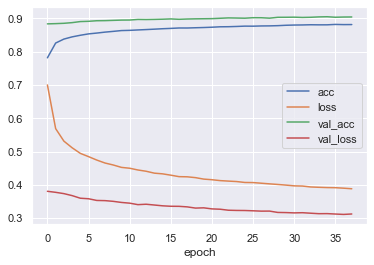

In [79]:
df.plot(x='epoch', y=['acc','loss','val_acc','val_loss'],grid=True)
plt.show()

In [70]:
# without dropout
df = pd.read_csv('csv_logger')

In [71]:
df.head()

,epoch,acc,loss,val_acc,val_loss
0,0,0.681140,1.093023,0.8172,0.636180
1,1,0.840655,0.555267,0.8526,0.518596
2,2,0.859570,0.485368,0.8661,0.466082
3,3,0.868665,0.450360,0.8690,0.451560
4,4,0.875260,0.426966,0.8768,0.421431


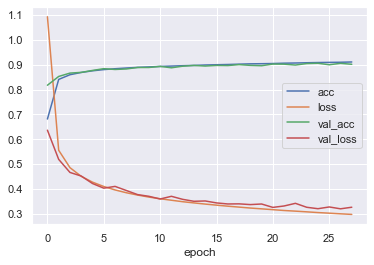

In [75]:
df.plot(x='epoch', y=['acc','loss','val_acc','val_loss'],grid=True)
plt.show()

more computional resources needed to train model.

In [82]:
N = 28*28
kernel_init = keras.initializers.TruncatedNormal(stddev=.1)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(.1,
                                                         decay_steps=10000,
                                                         decay_rate=.96,
                                                         staircase=True)
csv_logger = tf.keras.callbacks.CSVLogger('csv_logger')
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                                     mode='max',
                                                     patience=3)
checkpoint_path = 'tmp/notMNIST.cpk'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     monitor='val_acc',
                                                     verbose=1,
                                                     save_best_only=True,
                                                     load_weights_on_restart=True)

def train():
    tf.reset_default_graph()
    model = keras.models.Sequential([
        keras.layers.Conv2D(64, (3, 3), padding='same',
                           activation='relu', kernel_initializer=kernel_init, 
                            input_shape=(28,28,1)),
        keras.layers.MaxPooling2D(strides=2),
        keras.layers.Dropout(.25),
        keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                           kernel_initializer=kernel_init,
                           bias_initializer='ones'),
        keras.layers.MaxPooling2D(strides=2),
        keras.layers.Dropout(.25),
        keras.layers.Flatten(),
        keras.layers.Dense(4*N, activation='relu',kernel_initializer=kernel_init,
                          bias_initializer='ones'),
        keras.layers.Dropout(.5),
        keras.layers.Dense(2*N, activation='relu',kernel_initializer=kernel_init,
                          bias_initializer='ones'),
        keras.layers.Dropout(.3),
        keras.layers.Dense(N, activation='relu',kernel_initializer=kernel_init,
                          bias_initializer='ones'),
        keras.layers.Dropout(.5),
        keras.layers.Dense(10, activation='softmax', kernel_initializer=kernel_init,
                          bias_initializer='ones')
    ])
    model.compile(optimizer=keras.optimizers.SGD(lr_schedule),loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(train_dataset, train_labels, validation_data=(valid_dataset, valid_labels), epochs=100, 
              batch_size=1024, callbacks=[cp_callback,
                                     stop_callback,
                                     csv_logger])
    print("Model's performance on test dataset:")
    print(f"Test accuracy: {model.evaluate(test_dataset, test_labels)[1] * 100:.3f}%")
#     model.save('final_model.h5')
    return model